# Reactor Kinetics Example 

Jialu Wang (jwang44@nd.edu) and Alex Dowling (adowling@nd.edu)

University of Notre Dame

This notebook conducts design of experiments for a reactor kinetics experiment with the Pyomo.DOE.
    

In [1]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

import numpy as np
from scipy.interpolate import interp2d
import pandas as pd 
from itertools import permutations, product, combinations

from DoE_package import *
from pyomo.contrib.sensitivity_toolbox.sens import sipopt

## Define Reaction Example Mathematical Model

Consider two chemical reactions that converts molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$

Our ultimate goals is to design a large-scale continous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmasuticals, etc.).

The rate laws for these two chemical reactions are:

$r_A = -k_1 C_A$

$r_B = k_1 C_A - k_2 C_B$

$r_C = k_2 C_B$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$k_1 = A_1 \exp{\frac{-E_1}{R T}}$

$k_2 = A_2 \exp{\frac{-E_2}{R T}}$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

Using the **CCSI$^2$ toolset**, we would like do the following perform:

Perform **uncertainty quantification** and **design of experiments** on a small-scale **batch reactor** to infer parameters $A_1$, $A_2$, $E_1$, and $E_2$.

### Batch reactor

The concenrations in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

When the temperature is constant, it leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

In [2]:
from reactor_models import *

Three versions of this model is accomplished: 

Dynamic-DAE model: Temperature varying model discretized and integrated by Pyomo.DAE

Constant-DAE model: Temperature constant model discretized and integrated by Pyomo.DAE

Constant-analytical model: Temperature constant model discretized manually and using the analytical expressions for state variables.

In [3]:
# choose model from 'dynamic-DAE', 'constant-DAE', 'constant-analytical'
model_opt = 'dynamic-DAE'
#model_opt = 'constant-DAE'
#model_opt = 'constant-analytical'

if (model_opt=='dynamic-DAE'):
    createmod = create_model_dae
    disc = discretizer
    t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
    
elif (model_opt=='constant-DAE'):
    createmod = create_model_dae_const
    disc = discretizer
    t_control = [0]
    
elif (model_opt=='constant-analytical'):
    createmod = create_model_alge
    disc = None
    t_control = [0]

    
# design variable and its control time set
dv_pass = {'CA0': [0],'T': t_control}
    
# Define measurement time points
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

In [4]:
# Define parameter nominal value 
parameter_dict = {'A1': 84.79085853498033, 'A2': 371.71773413976416, 'E1': 7.777032028026428, 'E2': 15.047135137500822}

def generate_exp(t_set, CA0, T):  
    '''Generate experiments. 
    t_set: time control set for T.
    CA0: CA0 value
    T: A list of T 
    '''
    assert(len(t_set)==len(T)), 'T should have the same length as t_set'
    
    T_con_initial = {}
    for t, tim in enumerate(t_set):
        T_con_initial[tim] = T[t]
        
    dv_dict_overall = {'CA0': {0: CA0},'T': T_con_initial}
    return dv_dict_overall

In [5]:
# empty prior
#prior_all = np.zeros((4,4))


# add prior information
prior_5_300 = pd.read_csv('fim_5_300_scale.csv')
prior_5_300_500 = pd.read_csv('fim_5_300_500_scale.csv')

prior_all = prior_5_300_500


prior_pass=np.asarray(prior_all)

#L_initials = np.linalg.cholesky(prior_pass)
#print(L_initials)

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigvals(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigh(prior_pass)[1])

The prior information FIM: [[  28.67892806    5.41249739  -81.73674601  -24.02377324]
 [   5.41249739   26.40935036  -12.41816477 -139.23992532]
 [ -81.73674601  -12.41816477  240.46276004   58.76422806]
 [ -24.02377324 -139.23992532   58.76422806  767.25584508]]
Prior Det: 140189.67370995492
Eigenvalue of the prior experiments FIM: [8.00463185e+02 2.60471503e+02 4.84545259e-01 1.38765050e+00]
Eigenvalue of the prior experiments FIM: [[-0.77629273 -0.54211788  0.31871243 -0.0435912 ]
 [ 0.56614148 -0.80478003 -0.01425817 -0.177791  ]
 [-0.25919275 -0.19059651 -0.94009108  0.11278677]
 [ 0.09834911 -0.14869526  0.12019924  0.97661114]]


## Compute FIM 

This method computes an MBDoE optimization problem with no Degree of Freedom.

In [ ]:
# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'simultaneous_finite'
#sensi_opt = 'sequential_finite'
#sensi_opt = 'sequential_sipopt'
sensi_opt = 'sequential_kaug'

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

print('Design variable:', exp1)

In [ ]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 ['CA','CB','CC'], t_measure, createmod,
                                prior_FIM=prior_pass, discretize_model=disc)


if_s = True
result = doe_object.compute_FIM(exp1,mode=sensi_opt, FIM_store_name = 'dynamic.csv', scale_nominal_param_value=if_s, formula='central')


if sensi_opt == 'simultaneous_finite':
    result.extract_FIM(doe_object.m, doe_object.design_timeset,
                                                          doe_object.square_result, doe_object.obj_opt)
else: 
    result.calculate_FIM(doe_object.jac, doe_object.design_values)

In [ ]:
print('======Result summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(result.trace))
print('D-optimality:', np.log10(result.det))
print('E-optimality:', np.log10(result.min_eig))
print('Modified E-optimality:', np.log10(result.cond))

### Run sequential DOE automatically

This method runs a series of experiments in a row.

In [ ]:
exp1 = generate_exp(t_control, 5, [300])
exp2 = generate_exp(t_control, 5, [500.92])
exp3 = generate_exp(t_control, 5, [528])
exp4 = generate_exp(t_control, 5, [546.8])
exp5 = generate_exp(t_control, 5, [562])

In [ ]:

exp_all = [exp1, exp2, exp3, exp4, exp5]


doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 ['CA','CB','CC'], t_measure, createmod,
                                prior_FIM=prior_pass, discretize_model=disc)

# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'simultaneous_finite'
sensi_opt = 'sequential_finite'
#sensi_opt = 'sequential_sipopt'
if_s = True
result = doe_object.sequential_exp(exp_all, mode=sensi_opt, tee_option=True,
                                    scale_nominal_param_value=if_s, formula='central')

In [ ]:
print('=======Result summary=======')
for i in range(len(exp_all)):
    print('The ', i+1,'th experiment has optimality log10() values:')
    print('A-optimality:', np.log10(result[0][i].trace))
    print('D-optimality:', np.log10(result[0][i].det))
    print('E-optimality:', np.log10(result[0][i].min_eig))
    print('Modified E-optimality:', np.log10(result[0][i].cond))

### Run 1D analysis

Run 1D sensitivity analysis with one changing design variable

Note: this method can only deal with constant T problems

In [ ]:
# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])


In [ ]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 ['CA','CB','CC'], t_measure, createmod,
                                prior_FIM=prior_pass, discretize_model=disc)

# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'simultaneous_finite'
#sensi_opt = 'sequential_finite'
sensi_opt = 'sequential_sipopt'
if_s = True
result = doe_object.sensitivity_analysis_1D(exp1, {'T':[688,690]}, sensitivity_step=0.4, compare_opt='ME',
                                            mode=sensi_opt, tee_option=False,
                                    scale_nominal_param_value=if_s, formula='central')

In [ ]:
vary_range = list(result.keys())
result_list = list(result.values())

index_max = result_list.index(max(result_list))
index_min = result_list.index(min(result_list))

print('=======Result summary=======')
print('The biggest criterion value is:', max(result_list), ' at:', vary_range[index_max])
print('The smallest criterion value is:', min(result_list), ' at:', vary_range[index_min])

plt.plot(vary_range, result_list)
plt.xlabel('T [K]')
plt.ylabel('Design criteria')

## Optimization

In [ ]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

square_result, optimize_result = doe_object.optimize_doe(exp1, if_optimize=True, if_cho=True, scale_nominal_param_value=True, obj_opt='det', L_initial=None)


In [ ]:
print('======Result summary======')
print('This optimization is solved with status:', optimize_result.status)
print('It gives solution:', optimize_result.solution)
print('The log10(OF) optimized is:', optimize_result.obj_value)
print('The result FIM is:', optimize_result.FIM)

## heatmap 

In [6]:
design_ranges = [list(np.linspace(1,5,5)), list(np.linspace(300,700,5))]

dv_apply_name = ['CA0','T']

dv_apply_time = [[0],t_control]

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

In [7]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

all_fim = doe_object.run_grid_search(exp1, design_ranges,dv_apply_name, dv_apply_time, 
                                     mode='sequential_finite', 
                                    scale_nominal_param_value=True
                                    )

25  design vectors will be searched.
=======This is the  1 th iteration=======
Design variable values of this iteration: {'CA0': {0: 1.0}, 'T': {0: 300.0, 0.125: 300.0, 0.25: 300.0, 0.375: 300.0, 0.5: 300.0, 0.625: 300.0, 0.75: 300.0, 0.875: 300.0, 1: 300.0}}
Sensitivity information is scaled by its corresponding parameter nominal value.
Existed information has been added.
FIM: [[  29.58003272    5.48612156  -84.54627162  -24.46790912]
 [   5.48612156   27.13328151  -12.64771469 -143.60704229]
 [ -84.54627162  -12.64771469  249.22249067   60.14898186]
 [ -24.46790912 -143.60704229   60.14898186  793.6004921 ]]
Trace: 1099.5362969973296
Determinant: 151638.49432111066
Condition number: 1703.570882096611
Minimal eigen value: 0.48581739042098304
Eigen values: [8.27624360e+02 2.70029455e+02 4.85817390e-01 1.39666420e+00]
Eigen vectors: [[ 0.04300749 -0.31822906 -0.77652374  0.54211761]
 [ 0.17730502  0.01420751  0.56599113  0.80499386]
 [-0.1117473   0.94040674 -0.25890023  0.19004834]
 [-

Existed information has been added.
FIM: [[  29.66284896    5.98404272  -83.57738856  -26.09248409]
 [   5.98404272   27.73909098  -13.48736761 -144.05292682]
 [ -83.57738856  -13.48736761  243.90609069   62.63421243]
 [ -26.09248409 -144.05292682   62.63421243  784.67652324]]
Trace: 1085.9845538701272
Determinant: 188639.46155960692
Condition number: 1474.5971887933822
Minimal eigen value: 0.556052063178459
Eigen values: [8.19952809e+02 2.63907946e+02 5.56052063e-01 1.56774623e+00]
Eigen vectors: [[ 0.04594253 -0.320668   -0.77534136  0.54213199]
 [ 0.17974722  0.01448798  0.56676229  0.80390394]
 [-0.11695823  0.93879944 -0.26038706  0.19280809]
 [-0.97565414 -0.12497097  0.09912039  0.15052047]]
This is the  8  run out of  25 run.
The code has run 10.4313 seconds.
Estimated remaining time: 22.1664 seconds
=======This is the  9 th iteration=======
Design variable values of this iteration: {'CA0': {0: 2.0}, 'T': {0: 600.0, 0.125: 600.0, 0.25: 600.0, 0.375: 600.0, 0.5: 600.0, 0.625: 60

Existed information has been added.
FIM: [[  43.09660269    6.59048419 -126.68915571  -31.12994736]
 [   6.59048419   37.99224879  -16.09096346 -209.11379689]
 [-126.68915571  -16.09096346  380.61845015   80.9202888 ]
 [ -31.12994736 -209.11379689   80.9202888  1188.77019715]]
Trace: 1650.4774987815367
Determinant: 377289.91439240717
Condition number: 2481.5331584244427
Minimal eigen value: 0.4977587555539962
Eigen values: [1.23520486e+03 4.13290103e+02 4.97758756e-01 1.48478063e+00]
Eigen vectors: [[ 0.03730531 -0.3135781  -0.77866613  0.54217722]
 [ 0.1725762   0.01383184  0.56460354  0.80699999]
 [-0.10148488  0.9433793  -0.25614111  0.18473777]
 [-0.97904371 -0.10729839  0.09640345  0.14375966]]
This is the  16  run out of  25 run.
The code has run 20.7599 seconds.
Estimated remaining time: 11.6774 seconds
=======This is the  17 th iteration=======
Design variable values of this iteration: {'CA0': {0: 4.0}, 'T': {0: 400.0, 0.125: 400.0, 0.25: 400.0, 0.375: 400.0, 0.5: 400.0, 0.625:

Existed information has been added.
FIM: [[  32.4619363     7.89946484  -87.63421063  -31.52510018]
 [   7.89946484   30.55560188  -16.29518684 -151.74607207]
 [ -87.63421063  -16.29518684  249.65652506   70.45831361]
 [ -31.52510018 -151.74607207   70.45831361  804.97755722]]
Trace: 1117.651620471588
Determinant: 454517.0126153976
Condition number: 1059.799723292563
Minimal eigen value: 0.7970814142579506
Eigen values: [8.44746662e+02 2.69604107e+02 7.97081414e-01 2.50377024e+00]
Eigen vectors: [[ 0.05337759 -0.32661762 -0.74037869  0.58507364]
 [ 0.18442587  0.01338178  0.61386088  0.76745217]
 [-0.12811295  0.93486205 -0.25133676  0.21552227]
 [-0.97299795 -0.13847311  0.10883033  0.14918496]]
This is the  24  run out of  25 run.
The code has run 31.0215 seconds.
Estimated remaining time: 1.2926 seconds
=======This is the  25 th iteration=======
Design variable values of this iteration: {'CA0': {0: 5.0}, 'T': {0: 700.0, 0.125: 700.0, 0.25: 700.0, 0.375: 700.0, 0.5: 700.0, 0.625: 700

Design variable:  ['CA0', 'T']
Value          :  (1.0, 300.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 400.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 500.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 600.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 700.0)
Design variable:  ['CA0', 'T']
Value          :  (2.0, 300.0)
Design variable:  ['CA0', 'T']
Value          :  (2.0, 400.0)
Design variable:  ['CA0', 'T']
Value          :  (2.0, 500.0)
Design variable:  ['CA0', 'T']
Value          :  (2.0, 600.0)
Design variable:  ['CA0', 'T']
Value          :  (2.0, 700.0)
Design variable:  ['CA0', 'T']
Value          :  (3.0, 300.0)
Design variable:  ['CA0', 'T']
Value          :  (3.0, 400.0)
Design variable:  ['CA0', 'T']
Value          :  (3.0, 500.0)
Design variable:  ['CA0', 'T']
Value          :  (3.0, 600.0)
Design variable:  ['CA0', 'T']
Value          :  (3.0, 700.0)
Design variable:  ['CA0', 'T']
Value          :  (4.0, 300.0)
Design v

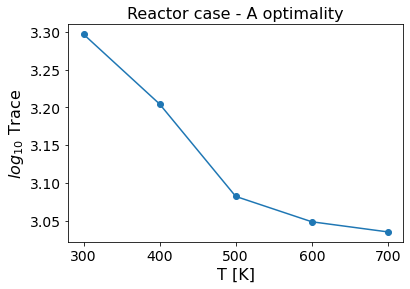

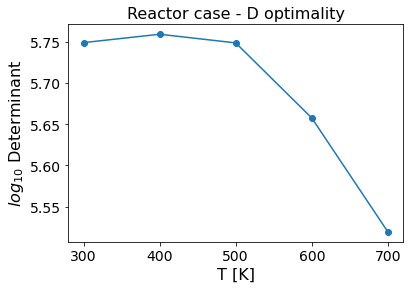

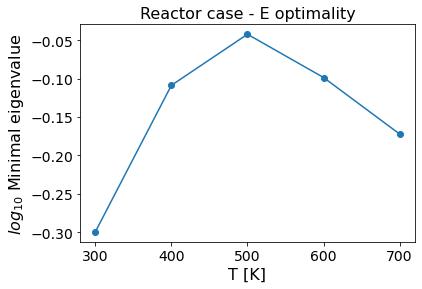

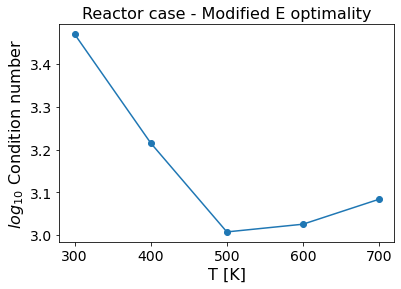

In [8]:
test = all_fim.extract_criteria()

## draw 1D sensitivity curve 

fixed = {"'CA0'": 5.0}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )



[1.0, 2.0, 3.0, 4.0, 5.0]
[300.0, 400.0, 500.0, 600.0, 700.0]
[1099.5362969973296, 1084.3283554734471, 1068.601301120078, 1065.0006727947682, 1063.6386428489946, 1209.7245373586702, 1148.8927705828396, 1085.9845538701272, 1071.5820381828053, 1066.133920780468, 1393.3716046200643, 1256.5001279889048, 1114.9566412208942, 1082.550986869459, 1070.2927173372873, 1650.4774987815367, 1407.150428212321, 1155.5175636475976, 1097.9075158546405, 1076.1150325090841, 1981.042219842969, 1600.8436715191028, 1207.6673231394532, 1117.651620471588, 1083.6008663180692]
[[1099.536297   1084.32835547 1068.60130112 1065.00067279 1063.63864285]
 [1209.72453736 1148.89277058 1085.98455387 1071.58203818 1066.13392078]
 [1393.37160462 1256.50012799 1114.95664122 1082.55098687 1070.29271734]
 [1650.47749878 1407.15042821 1155.51756365 1097.90751585 1076.11503251]
 [1981.04221984 1600.84367152 1207.66732314 1117.65162047 1083.60086632]]


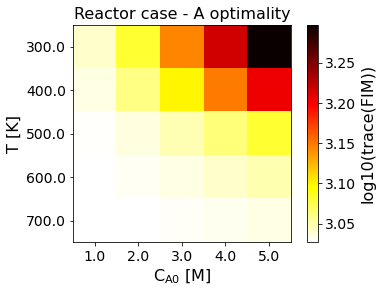

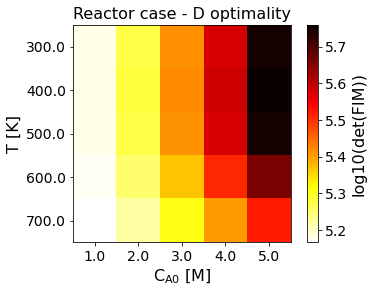

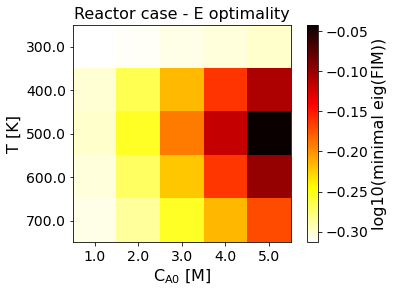

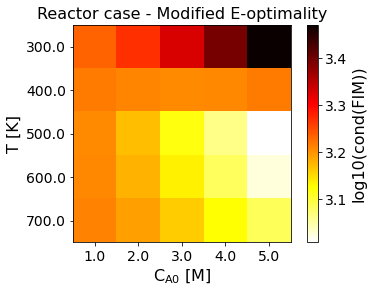

In [9]:
fixed = {}

#docc = all_fim.figure_result_data 
#docc.loc[(docc['CA0']==1.0) & (docc['T']==300.0)]

all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

In [ ]:
#design_ranges = {'CA0':list(np.linspace(1,5,9)),  'T': list(np.linspace(300,700,9))}
design_ranges = [list(np.linspace(1,5,2)),  list(np.linspace(300,700,2)), [300,500]]

#dv_apply_time = {'CA0': [0], 'T': t_control}
dv_apply_name = ['CA0', 'T', 'T']
dv_apply_time = [[0], [0], [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875,1]]

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

In [ ]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

all_fim = doe_object.run_grid_search(exp1, design_ranges,dv_apply_name, dv_apply_time, 
                                     mode='sequential_finite', 
                                    scale_nominal_param_value=True
                                    )

### Draw heatmap figures

In [ ]:
test = all_fim.extract_criteria()
print(test)

In [ ]:
## draw 1D sensitivity curve 

fixed = {"'CA0'": 1.0, "'T2'": 300}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )

In [ ]:

docc = all_fim.figure_result_data 
#docc.loc[(docc['CA0']==1.0) & (docc['T']==300.0)]['A'].values.tolist()



#aa = [1,1,4,4]
#print(set(aa))
#print(list(set(aa)))

In [ ]:
fixed = {"'T2'": 300}
#print(all_fim.figure_result_data)

docc = all_fim.figure_result_data 
docc.loc[(docc['CA0']==1.0) & (docc['T']==300.0)]

all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

In [ ]:
heatmap = Grid_Search_Result(design_ranges, all_fim, store_optimality_name='test_heatmap.csv')

heatmap.heatmap('Reactor case', '$C_{A0}$ [M]', 'T [K]')

In [ ]:
x = [1,2]
y = [44, 55]

fig = plt.figure()
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
ax = fig.add_subplot(111)
params = {'mathtext.default': 'regular'}
plt.rcParams.update(params)
ax.plot(x, y)
ax.set_yticks(range(len(yLabel)))
ax.set_yticklabels(yLabel)
ax.set_ylabel(ylabel_text)
ax.set_xticks(range(len(xLabel)))
ax.set_xticklabels(xLabel)
ax.set_xlabel(xlabel_text)
plt.title(title_text + ' - A optimality')
plt.show()

In [ ]:
filter = ''
for i in range(2):
    filter += '(self.store_all_results_dataframe['
    filter += "'CA0'"
    filter += ']=='
    filter += str(500)
    filter += ')'
    if i != 1:
        filter += '&'
        
print(filter)

In [ ]:
d = [test['CA0']==1.0, test['T2']==500]
print(d)

print(type((test['CA0']==1.0) & (test['T2']==500)))

In [ ]:
ff = ''
for i in range(5):
    ff += str(i)
    
print(ff)

In [ ]:
#new_test = test.loc[(test['CA0']==1.0) & (test['T2']==500)]
dd = eval('(test["CA0"]' + '==' + str(1.0) + ')&(' + 'test["T2"]' + '==' + str(500)+')')

new_test = test.loc[dd]
print(new_test)

x_list = new_test['T'].values.tolist()
A_list = new_test['A'].values.tolist()

print(x_list)
print(A_list)

### 1D heatmap

In [ ]:
#design_ranges = {'CA0':list(np.linspace(1,5,9)),  'T': list(np.linspace(300,700,9))}
design_ranges = [ list(np.linspace(300,700,5))]

dv_apply_name = ['T']
dv_apply_time = [t_control]

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

In [ ]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

all_fim = doe_object.run_grid_search(exp1, design_ranges,dv_apply_name, dv_apply_time, 
                                     mode='sequential_finite', 
                                    scale_nominal_param_value=True
                                    )

In [ ]:
heatmap = Grid_Search_Result(design_ranges, all_fim, store_optimality_name='test_heatmap.csv')

heatmap.heatmap('Reactor case', '$C_{A0}$ [M]', 'T [K]')

In [ ]:
col_names = dv_apply_name.copy()
col_names.append('A')
print(col_names)